In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [36]:
#I added corresponding headers to each column to facilitate processing
dataframe = pd.read_csv("layton_wildprocessed", header = 0)  
#print (dataframe)
dataframe = dataframe.drop("tmp1", axis = 1)
data = dataframe.drop("tmp2", axis = 1)
# print (df)
# df.plot(x='emg',y = 'x')
# df.head()

In [58]:
#These are the quantative features we need to normalize (all four dimensional inputs)
quant_features = ['emg', 'x', 'y', 'z']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
# print (data)

In [41]:
#Divide date into testing and training sets
test_data = data[9000:]
train_data = data[:9000]
# print(test_data)

In [47]:
target_fields = ['x', 'y', 'z']
features, targets = train_data, train_data[target_fields]
# print(features,targets)
test_features, test_targets = test_data, test_data[target_fields]
# print(test_features,test_targets)

In [105]:
#divide training data into training and validation sets
train_features, train_targets = features[:-2000], targets[:-2000]
val_features, val_targets = features[-2000:], targets[-2000:]
# print (val_features, val_targets)

#print (train_features.shape[1])

In [106]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # Activation function is the sigmoid function, we could also use lamda notation here

        self.activation_function = sigmoid

    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        ### Forward pass ###
        # Hidden layer 
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        ### Backward pass ###
        
        # Output error
        output_errors =  targets - final_outputs
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)  
        hidden_grad = hidden_outputs * (1 - hidden_outputs) 
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * np.dot((hidden_errors * hidden_grad), inputs.T)   
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T

        #### Implementation of the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Output layer
        final_outputs = np.dot(self.weights_hidden_to_output, hidden_outputs)

        return final_outputs

In [135]:
import sys

### Set the hyperparameters here ###
epochs = 50
learning_rate = 0.02
hidden_nodes = 6
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for t in target_fields:
    print ("Now training for " + str(t))
    for e in range(epochs):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        for record, target in zip(train_features.ix[batch].values, 
                                  train_targets.ix[batch][t]):
            network.train(record, target)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features), train_targets[t].values)
        val_loss = MSE(network.run(val_features), val_targets[t].values)
#         sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:5] \
#                          + "% ... Training loss: " + str(train_loss)[:6] \
#                          + " ... Validation loss: " + str(val_loss)[:6])
        
        print ("\rProgress: " + str(100 * e/float(epochs))[:5] \
                         + "% ... Training loss: " + str(train_loss)[:6] \
                         + " ... Validation loss: " + str(val_loss)[:6])
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)

Now training for x
Progress: 0.0% ... Training loss: 0.1551 ... Validation loss: 0.1389
Progress: 2.0% ... Training loss: 0.0513 ... Validation loss: 0.0389
Progress: 4.0% ... Training loss: 0.0361 ... Validation loss: 0.0373
Progress: 6.0% ... Training loss: 0.0338 ... Validation loss: 0.0418
Progress: 8.0% ... Training loss: 0.0280 ... Validation loss: 0.0344
Progress: 10.0% ... Training loss: 0.0252 ... Validation loss: 0.0289
Progress: 12.0% ... Training loss: 0.0215 ... Validation loss: 0.0236
Progress: 14.0% ... Training loss: 0.0190 ... Validation loss: 0.0227
Progress: 16.0% ... Training loss: 0.0180 ... Validation loss: 0.0126
Progress: 18.0% ... Training loss: 0.0154 ... Validation loss: 0.0110
Progress: 20.0% ... Training loss: 0.0126 ... Validation loss: 0.0114
Progress: 22.0% ... Training loss: 0.0111 ... Validation loss: 0.0095
Progress: 24.0% ... Training loss: 0.0100 ... Validation loss: 0.0065
Progress: 26.0% ... Training loss: 0.0087 ... Validation loss: 0.0059
Progre

Progress: 66.0% ... Training loss: 0.0036 ... Validation loss: 0.0146
Progress: 68.0% ... Training loss: 0.0034 ... Validation loss: 0.0164
Progress: 70.0% ... Training loss: 0.0033 ... Validation loss: 0.0151
Progress: 72.0% ... Training loss: 0.0033 ... Validation loss: 0.0148
Progress: 74.0% ... Training loss: 0.0033 ... Validation loss: 0.0152
Progress: 76.0% ... Training loss: 0.0032 ... Validation loss: 0.0155
Progress: 78.0% ... Training loss: 0.0039 ... Validation loss: 0.0141
Progress: 80.0% ... Training loss: 0.0031 ... Validation loss: 0.0146
Progress: 82.0% ... Training loss: 0.0032 ... Validation loss: 0.0153
Progress: 84.0% ... Training loss: 0.0031 ... Validation loss: 0.0141
Progress: 86.0% ... Training loss: 0.0030 ... Validation loss: 0.0146
Progress: 88.0% ... Training loss: 0.0030 ... Validation loss: 0.0144
Progress: 90.0% ... Training loss: 0.0029 ... Validation loss: 0.0146
Progress: 92.0% ... Training loss: 0.0030 ... Validation loss: 0.0158
Progress: 94.0% ... 

The first 100 epoches are for x; the second 100 epoches are for y; the last 100 epoches are for z


(-0.018206210525782307, 0.3)

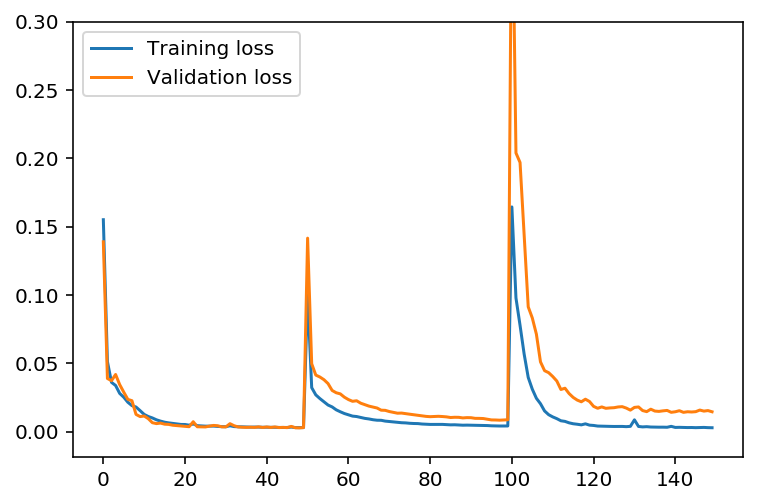

In [136]:
print ("The first 100 epoches are for x; the second 100 epoches are for y; the last 100 epoches are for z")
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.3)

## TODO

* More tests on the results; especially on measuring the errors; (Maybe cross-validation?)